In [1]:
!uv pip install pandas matplotlib requests ipinfo

Audited 4 packages in 15ms


In [110]:
import ipinfo
import pandas as pd
from time import sleep
import scapy.all as scapy
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [111]:
def dns_resolve(domain):
    url = "https://dns.google/resolve"
    params = {
        "name": domain,
        "type": "A"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if "Answer" in data:
            ip_addresses = [answer["data"] for answer in data["Answer"] if answer["type"] == 1]
            return ip_addresses[0]
        else:
            return "???"
    except:
        return "???"

In [112]:
access_token = '7caf0a02fdc298'
handler = ipinfo.getHandler(access_token)

def to_org(ip):
    
    try:
        details = handler.getDetails(ip)
    except:
        new_ip = dns_resolve(ip)
        if new_ip == "???":
            return "???"
            
        details = handler.getDetails(dns_resolve(ip))
    
    sleep(0.03)
    try:
        return details.all['org']
    except:
        return "???"


df = pd.read_parquet('dns_responses_priv.parquet')

grouped_df = df.groupby('rdata').size().reset_index(name='count')

In [116]:
org = list()
for i in tqdm(range( grouped_df.shape[0])):
    org.append(to_org(grouped_df['rdata'][i]))


  0%|          | 0/27 [00:00<?, ?it/s]

In [117]:
with open('org_priv.txt', 'w') as f:
    for o in org:
        f.write(o + "\n")

In [118]:
grouped_df['org'] = org

In [121]:
grouped_df.head(100) 

,rdata,count,org
0,104.18.3.31,1,"AS13335 Cloudflare, Inc."
1,104.26.11.73,1,"AS13335 Cloudflare, Inc."
2,145.131.90.136,1,AS28685 Routit BV
3,172.65.90.5,1,"AS13335 Cloudflare, Inc."
4,185.196.102.116,4,AS49282 Ficolo Oy
5,185.196.102.117,3,AS49282 Ficolo Oy
6,185.199.111.153,1,"AS54113 Fastly, Inc."
7,185.205.69.12,5,AS210909 Tutao GmbH
8,185.226.149.25,1,AS50304 Blix Solutions AS
9,185.67.36.168,2,AS8495 INTERNET AG Global Network


In [122]:
grouped_df.to_csv('data_priv.csv')

grouped_df['as'] = grouped_df['org'].apply(lambda a: a.split(' ')[0])
grouped_df['org_name'] = grouped_df['org'].apply(lambda a: " ".join(a.split(' ')[1:]))

by_asn = grouped_df.groupby('org').size().reset_index(name='#')


In [123]:
by_asn.shape[0]

15

In [124]:
test = grouped_df.groupby('org_name').size().reset_index(name='#')

In [125]:
by_asn.nlargest(20, '#')

,org,#
1,"AS13335 Cloudflare, Inc.",5
10,AS49282 Ficolo Oy,4
13,AS62371 Proton AG,4
9,"AS32244 Liquid Web, L.L.C",2
14,AS8495 INTERNET AG Global Network,2
0,AS11042 NETWORK TRANSIT HOLDINGS LLC,1
2,AS13768 Aptum Technologies,1
3,"AS14061 DigitalOcean, LLC",1
4,AS16276 OVH SAS,1
5,AS16652 Riseup Networks,1


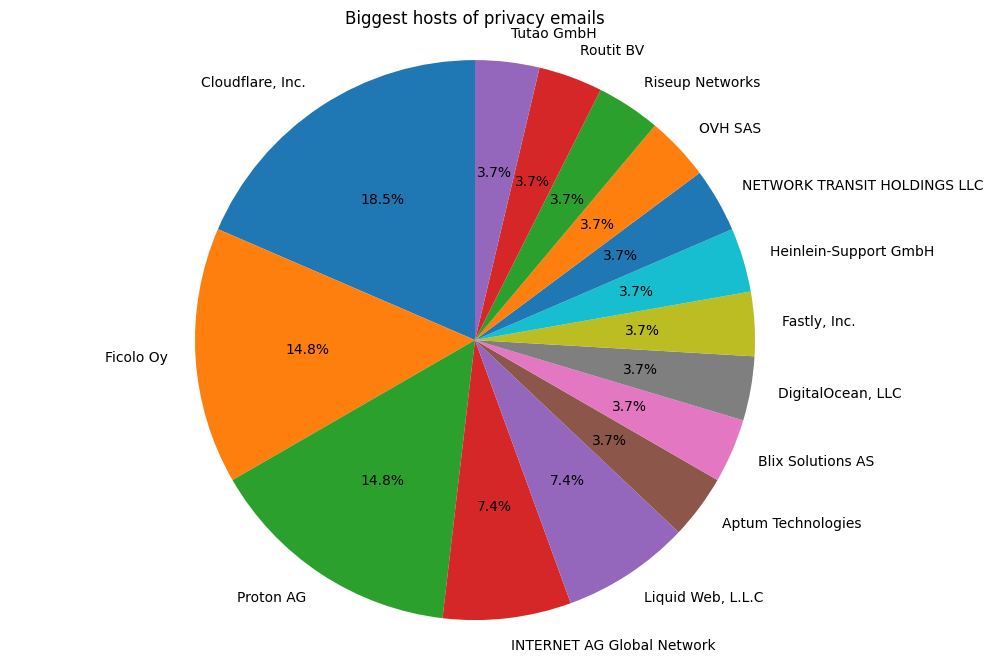

In [133]:

top_data = test.nlargest(15, '#')

others_sum = test['#'].sum() - top_data['#'].sum()
if others_sum != 0:
    other_data = pd.DataFrame({'#': [others_sum], 'org_name': ['Other']})
    top_data = pd.concat([top_data, other_data], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(top_data['#'], labels=top_data['org_name'], autopct='%1.1f%%', startangle=90)
plt.title('Biggest hosts of privacy emails')
plt.axis('equal')
plt.savefig('priv_pie.png')
plt.show()


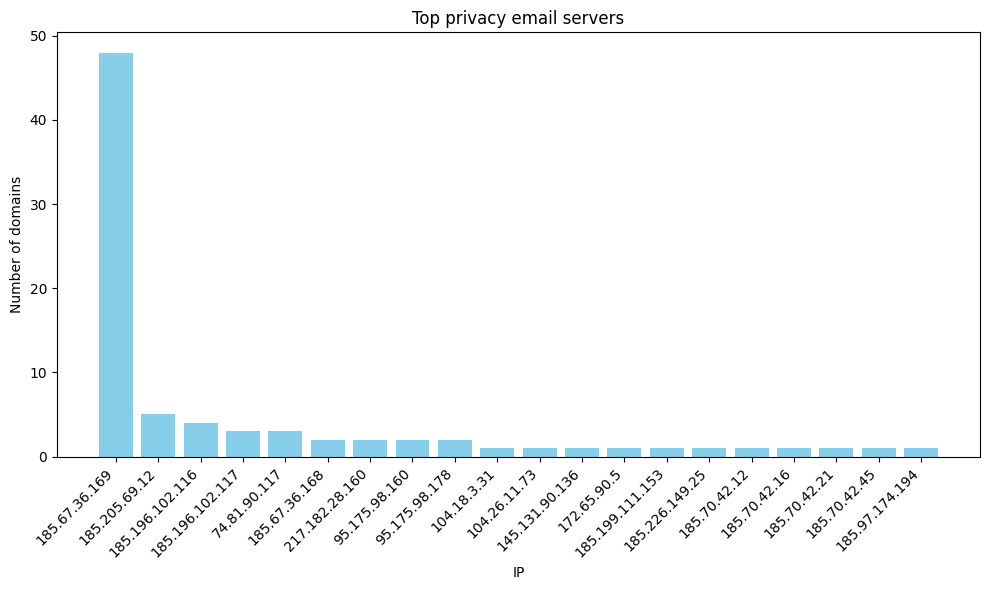

In [129]:
import matplotlib.pyplot as plt


top_10_rdata = grouped_df.nlargest(20, 'count') 

plt.figure(figsize=(10, 6))
plt.bar(top_10_rdata['rdata'], top_10_rdata['count'], color='skyblue')
plt.xlabel('IP')
plt.ylabel('Number of domains')
plt.title('Top privacy email servers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('priv_bar.png')

plt.show()